In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
!pip install -q keras

In [0]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
import numpy as np
import time
from tensorflow.examples.tutorials.mnist import input_data
from keras.datasets import mnist

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Reshape
from keras.layers import Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers import LeakyReLU, Dropout
from keras.layers import BatchNormalization
from keras.optimizers import Adam, RMSprop

import matplotlib.pyplot as plt

In [0]:
data = input_data.read_data_sets("mnist", one_hot=True).train.images
data = data.reshape(-1, 28, 28, 1).astype(np.float32)
print(data[0])

In [0]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(-1, 28, 28, 1).astype(np.float32)

x_train = 1.0/255*x_train

print(y_train[2])

In [0]:
class ElapsedTimer(object):
    def __init__(self):
        self.start_time = time.time()
    def elapsed(self,sec):
        if sec < 60:
            return str(sec) + " sec"
        elif sec < (60 * 60):
            return str(sec / 60) + " min"
        else:
            return str(sec / (60 * 60)) + " hr"
    def elapsed_time(self):
        print("Elapsed: %s " % self.elapsed(time.time() - self.start_time) )

In [0]:
class MNIST_Classifier(object):
    def __init__(self, input_shape):
        self.classifier = self.classifier_model(input_shape)
        self.classifier.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        self.classifier.load_weights("/content/drive/My Drive/mnist_gan/classifier.h5")
    
    def classifier_model(self, input_shape):
        model = Sequential()
        model.add(Flatten(input_shape = input_shape))
        model.add(Dense(128, activation='relu'))
        model.add(Dense(128, activation='relu'))
        model.add(Dense(10, activation='softmax'))

#         model.summary()
        return model

In [0]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

mnist_classifier = MNIST_Classifier()

# c.classifier.fit(x_train, y_train, epochs=20, batch_size=500)

val_loss, val_acc = mnist_classifier.classifier.evaluate(x_test, y_test)
print("val_loss: ", val_loss, "val_acc", val_acc)

# classifier_json = c.classifier.to_json()
# with open("/content/drive/My Drive/mnist_gan/classifier.json", "w") as classifier_json_file:
#     classifier_json_file.write(classifier_json)
# c.classifier.save_weights("/content/drive/My Drive/mnist_gan/classifier.h5")

10000/10000 [==============================] - 1s 144us/step
val_loss:  0.5382646422702306 val_acc 0.9647


In [0]:
class DCGAN(object):
    def __init__(self, img_rows=28, img_cols=28, channel=1):

        self.img_rows = img_rows
        self.img_cols = img_cols
        self.channel = channel
        self.D = self.discriminator()   # discriminator
        
        self.optimizer = Adam(lr=0.0002, beta_1=0.5, decay=8e-8)
        self.G = self.generator()   # generator
        self.G.compile(loss='binary_crossentropy', optimizer=self.optimizer, metrics=['accuracy'])

        self.dm_optimizer = RMSprop(lr=0.0002, decay=6e-8)
        self.DM = self.discriminator_model()  # discriminator model
        self.DM.compile(loss='binary_crossentropy', optimizer=self.dm_optimizer, metrics=['accuracy'])
        
        self.DM.load_weights("/content/drive/My Drive/mnist_gan/discriminator_model.h5")
        
        self.am_optimizer = RMSprop(lr=0.0001, decay=3e-8)
        self.AM = self.adversarial_model()  # adversarial model
        self.AM.compile(loss='binary_crossentropy', optimizer=self.am_optimizer, metrics=['accuracy'])
        
        self.AM.load_weights("/content/drive/My Drive/mnist_gan/adversarial_model.h5")


    # (W−F+2P)/S+1
    def discriminator(self):
        model = Sequential()
        depth = 64
        dropout = 0.4
        # In: 28 x 28 x 1, depth = 1
        # Out: 14 x 14 x 1, depth=64
        input_shape = (self.img_rows, self.img_cols, self.channel)
        model.add(Conv2D(depth*1, 5, strides=2, input_shape=input_shape, padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(dropout))

        model.add(Conv2D(depth*2, 5, strides=2, padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(dropout))

        model.add(Conv2D(depth*4, 5, strides=2, padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(dropout))

        model.add(Conv2D(depth*8, 5, strides=1, padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(dropout))

        # Out: 1-dim probability
        model.add(Flatten())
        model.add(Dense(1))
        model.add(Activation('sigmoid'))
#         model.summary()
        return model

    def generator(self):
        model = Sequential()
        dropout = 0.4
        depth = 64+64+64+64
        dim = 7
        # In: 100
        # Out: dim x dim x depth
        model.add(Dense(dim*dim*depth, input_dim=100))
        model.add(BatchNormalization(momentum=0.9))
        model.add(Activation('relu'))
        model.add(Reshape((dim, dim, depth)))
        model.add(Dropout(dropout))

        # In: dim x dim x depth
        # Out: 2*dim x 2*dim x depth/2
        model.add(UpSampling2D())
        model.add(Conv2DTranspose(int(depth/2), 5, padding='same'))
        model.add(BatchNormalization(momentum=0.9))
        model.add(Activation('relu'))

        model.add(UpSampling2D())
        model.add(Conv2DTranspose(int(depth/4), 5, padding='same'))
        model.add(BatchNormalization(momentum=0.9))
        model.add(Activation('relu'))

        model.add(Conv2DTranspose(int(depth/8), 5, padding='same'))
        model.add(BatchNormalization(momentum=0.9))
        model.add(Activation('relu'))

        # Out: 28 x 28 x 1 grayscale image [0.0,1.0] per pix
        model.add(Conv2DTranspose(1, 5, padding='same'))
        model.add(Activation('sigmoid'))
#         model.summary()
        return model

    def discriminator_model(self):
        model = Sequential()
        model.add(self.D)
        return model

    def adversarial_model(self):

        self.D.trainable = False # freeze the discriminator weights

        model = Sequential()
        model.add(self.G)
        model.add(self.D)
        return model

In [0]:
class MNIST_DCGAN(object):
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channel = 1

#         self.x_train = input_data.read_data_sets("mnist", one_hot=True).train.images
#         self.x_train = self.x_train.reshape(-1, self.img_rows, self.img_cols, 1).astype(np.float32)
        
        (x_train, y_train), (x_test, y_test) = mnist.load_data()
        x_train = x_train.reshape(-1, 28, 28, 1).astype(np.float32)
        self.x_train = 1.0/255*x_train
        self.y_train = y_train

        self.DCGAN = DCGAN()
        self.discriminator =  self.DCGAN.DM
        self.adversarial = self.DCGAN.AM
        self.generator = self.DCGAN.G
        
        self.mnist_classifier = MNIST_Classifier(x_test[0].shape)

    def train(self, train_steps=2000, batch_size=256, save_interval=0):
        noise_input = None
        if save_interval>0:
            noise_input = np.random.uniform(-1.0, 1.0, size=[16, 100])
        for i in range(train_steps):
            images_train = self.x_train[np.random.randint(0, self.x_train.shape[0], size=batch_size), :, :, :]
            noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
            images_fake = self.generator.predict(noise)
            x = np.concatenate((images_train, images_fake))
            y = np.ones([2*batch_size, 1])
            y[batch_size:, :] = 0
            
            #train discriminator
            d_loss = self.discriminator.train_on_batch(x, y)

            y = np.ones([batch_size, 1])
            noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
            
            #train adversarial
            a_loss = self.adversarial.train_on_batch(noise, y)
            
            log_mesg = "%d: [D loss: %f, acc: %f]" % (i, d_loss[0], d_loss[1])
            log_mesg = "%s  [A loss: %f, acc: %f]" % (log_mesg, a_loss[0], a_loss[1])
            print(log_mesg)
            
            if save_interval>0:
                if (i+1)%save_interval==0:
                    self.plot_images(save2file=True, samples=noise_input.shape[0], noise=noise_input, step=(i+1))
                    
                    # Save discriminator model
                    discriminator_model_json = self.discriminator.to_json()
                    with open("/content/drive/My Drive/mnist_gan/discriminator_model.json", "w") as discriminator_json_file:
                        discriminator_json_file.write(discriminator_model_json)
                    self.discriminator.save_weights("/content/drive/My Drive/mnist_gan/discriminator_model.h5")

                    # Save adversarial model
                    adversarial_model_json = self.adversarial.to_json()
                    with open("/content/drive/My Drive/mnist_gan/adversarial_model.json", "w") as adversarial_json_file:
                        adversarial_json_file.write(adversarial_model_json)
                    self.adversarial.save_weights("/content/drive/My Drive/mnist_gan/adversarial_model.h5")
                    

    def predict_with_mnist_classifier(self, images, samples):
        images = images.reshape(samples, self.img_rows, self.img_cols)
        prediction = self.mnist_classifier.classifier.predict(images)
        prediction = np.array([np.argmax(p) for p in prediction])
        return prediction
                    
    def plot_images(self, save2file=False, fake=True, samples=16, noise=None, step=0):
        filename = 'mnist.png'
        if fake:
            if noise is None:
                noise = np.random.uniform(-1.0, 1.0, size=[samples, 100])
            else:
                filename = "mnist_%d.png" % step
            images = self.generator.predict(noise)
        else:
#             i = np.random.randint(0, self.x_train.shape[0], samples)
            i = range(samples)
            images = self.x_train[i, :, :, :]
            print("y_train", y_train[:samples])
            
        prediction = self.predict_with_mnist_classifier(images, samples)
        print("prediction", prediction)

        plt.figure(figsize=(10,10))
        for i in range(images.shape[0]):
            plt.subplot(4, 4, i+1)
            image = images[i, :, :, :]
            image = np.reshape(image, [self.img_rows, self.img_cols])
            plt.imshow(image, cmap='gray')
            plt.axis('off')
        plt.tight_layout()
        if save2file:
            print("Saving result...")
            plt.savefig('/content/drive/My Drive/mnist_gan/secureResults/'+filename)
            plt.close('all')
        else:
            plt.show()

prediction [1 2 9 6 2 6 2 2 9 4 4 6 3 6 4 0]


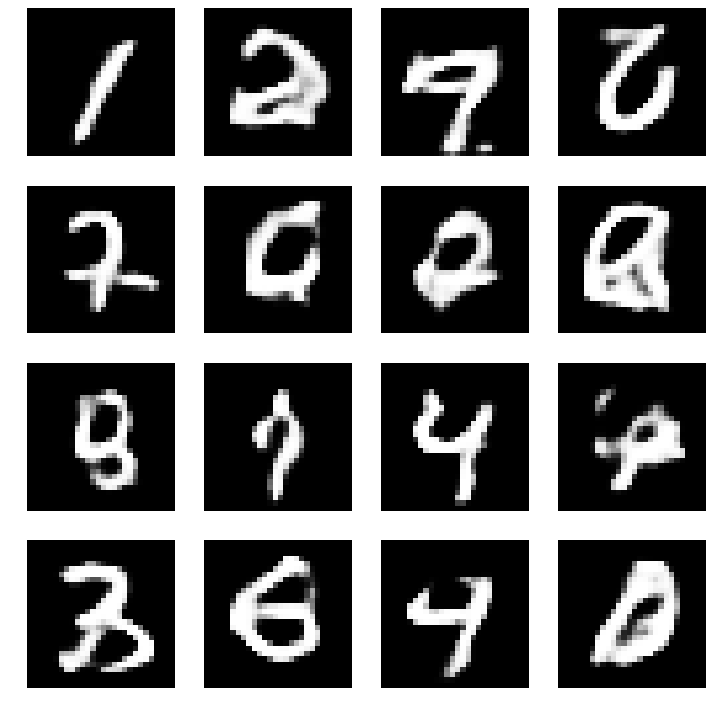

In [0]:
mnist_dcgan = MNIST_DCGAN()
mnist_dcgan.plot_images(fake=True, save2file=False)

In [0]:
mnist_dcgan = MNIST_DCGAN()
timer = ElapsedTimer()
mnist_dcgan.train(train_steps=1000, batch_size=256, save_interval=100)
timer.elapsed_time()
mnist_dcgan.plot_images(fake=True, save2file=True)
mnist_dcgan.plot_images(fake=False, save2file=True)